In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 28 June 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates

# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')


In [2]:
client = Client(n_workers=56,threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39925/status,
Dashboard: /proxy/39925/status,Workers: 56
Total threads: 56,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35709,Workers: 56
Dashboard: /proxy/39925/status,Total threads: 56
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46313,Total threads: 1
Dashboard: /proxy/33153/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42207,


In [138]:
%%time

# load ice draft to create masks
di = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

contour_depth = 1500.

## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
 



CPU times: user 93.5 ms, sys: 25 ms, total: 118 ms
Wall time: 99.9 ms


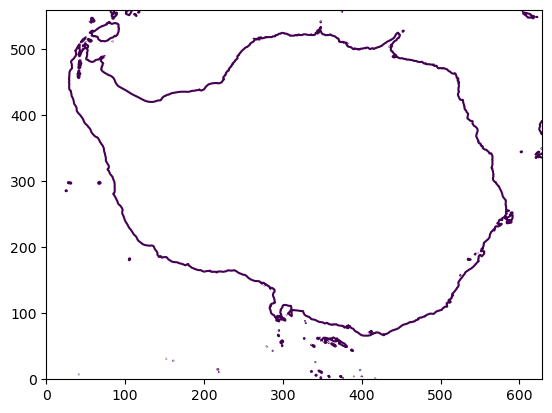

In [140]:
sc = plt.contour(h, levels=[1500])


In [171]:
# # first save all contours in individual plot to scam for the number of the desired contour:

# for cc in np.arange(0,213):
#     fig = plt.figure(figsize = (8, 6))
#     count = cc
#     x_contour = []
#     y_contour = []

#     # Create the contour:
#     sc = plt.contour(h, levels=[contour_depth])
#     for collection in sc.collections:
#         for path in collection.get_paths():
#             # print(collection.get_paths())
        
#             count += 1
#             if count ==  212:
#                 # Write down the lat/lon indices
#                 for ii in range(np.size(path.vertices[:,0])):
#                     x_contour.append(int(np.round(path.vertices[ii][0])))
#                     y_contour.append(int(np.round(path.vertices[ii][1])))

#     plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/waom10extend_1500m_contour_cc=" + str(cc) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

# THIS DOESN'T WORK ANYMORE (FEB24); IT KEEP GATHERING ALL CONTOURS. HAD TO SEPARATE IT MANUALLY (SEE BELOW).

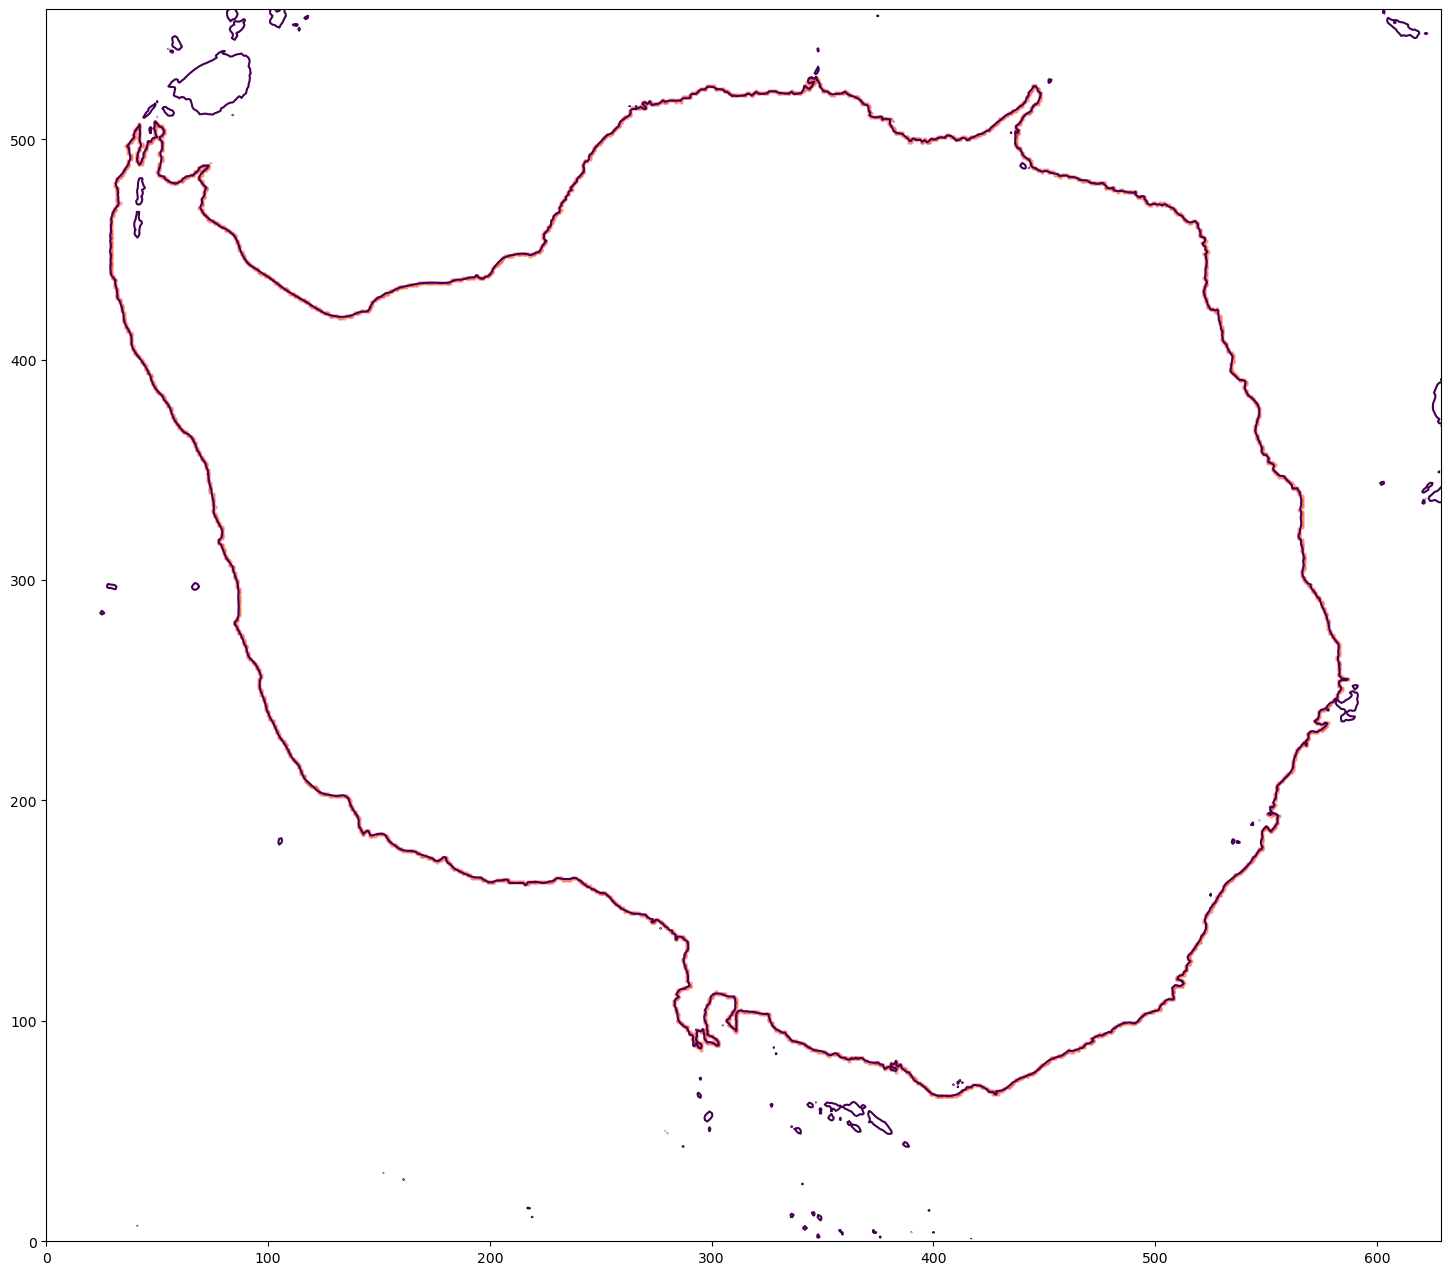

In [179]:
fig = plt.figure(figsize = (18, 16))
count = 0
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        
        count += 1
        
        if count == 1:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

xi=494
xf=3279
plt.scatter(x_contour[xi:xf], y_contour[xi:xf], s=5, alpha=0.5, color='tomato');

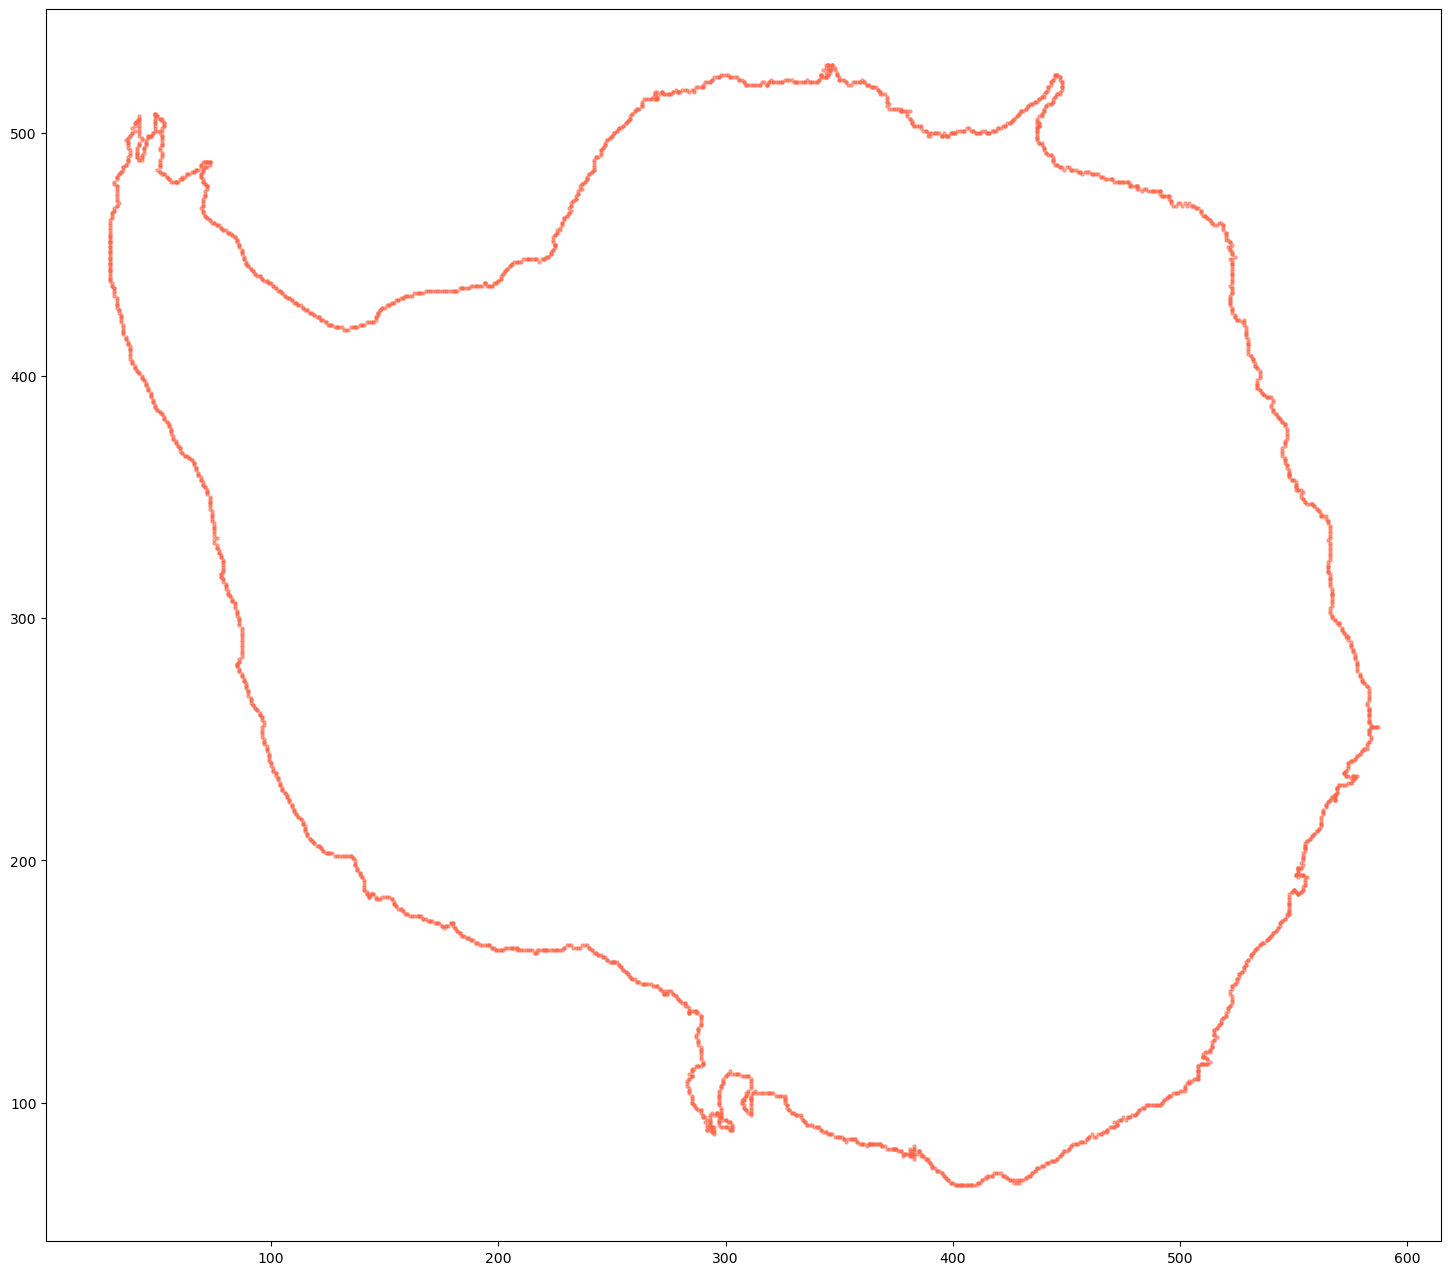

In [184]:
x_contour = x_contour[xi:xf]
y_contour = y_contour[xi:xf]

fig = plt.figure(figsize = (18, 16))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');


In [185]:
len(x_contour)

2785

In [186]:
# save x_contour, y_contour

xcon_np = np.asarray(x_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv", xcon_np, delimiter=",")

ycon_np = np.asarray(y_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv", ycon_np, delimiter=",")

# reloading...
# xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv")
# x_contour2 = xcon_np.tolist()
# ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv")
# y_contour2 = ycon_np.tolist()


In [6]:
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv")
x_contour = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv")
y_contour = ycon_np.tolist()

In [21]:
# for ii in range(0,len(x_contour)):
#         # ?contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1
#         print(int(y_contour[ii]), int(x_contour[ii]))